In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/var/folders/tx/45hhw1yn48jfdqn2hmnhbhvw0000gn/T/ipykernel_47901/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Lab | Natural Language Processing
### SMS: SPAM or HAM

### Let's prepare the environment

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

- Read Data for the Fraudulent Email Kaggle Challenge
- Reduce the training set to speead up development. 

In [3]:
## Read Data for the Fraudulent Email Kaggle Challenge
data = pd.read_csv("../data/kg_train.csv",encoding='latin-1')

# Reduce the training set to speed up development. 
# Modify for final system
data = data.head(1000)
print(data.shape)
data.fillna("",inplace=True)

(1000, 2)


In [4]:
data

,text,label
0,"DEAR SIR, STRICTLY A PRIVATE BUSINESS PROPOSAL...",1
1,Will do.,0
2,Nora--Cheryl has emailed dozens of memos about...,0
3,Dear Sir=2FMadam=2C I know that this proposal ...,1
4,fyi,0
...,...,...
995,So what's the latest? It sounds contradictory ...,0
996,"TRANSFER OF 36,759,000.00 MILLION POUNDS TO YO...",1
997,Barb I will call to explain. Are you back in t...,0
998,Yang on travelNot free tonite.May work tomorrow,0


### Let's divide the training and test set into two partitions

In [5]:
# Your code

from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

print(f"Training set size: {len(data_train)}")
print(f"Validation set size: {len(data_val)}")


Training set size: 800
Validation set size: 200


In [6]:
# Let's see some examples of spam and ham messages
print("=== SPAM MESSAGES ===")
spam_examples = data[data['label'] == 1]['text'].head(3)
for i, msg in enumerate(spam_examples):
    print(f"{i+1}. {msg[:100]}...")  # Show first 100 characters

print("\n=== HAM MESSAGES ===")  
ham_examples = data[data['label'] == 0]['text'].head(3)
for i, msg in enumerate(ham_examples):
    print(f"{i+1}. {msg[:100]}...")

=== SPAM MESSAGES ===
1. DEAR SIR, STRICTLY A PRIVATE BUSINESS PROPOSAL I AM MIKE CHUKWU , THE MANAGER, BILLS AND EXCHANGE AT...
2. Dear Sir=2FMadam=2C I know that this proposal might be a surprise to you but it as an emergency=2EIn...
3. Dear Sir,I am Engr. Ugo Nzego with the Engineering Stores Department of the Federal Ministry of Agri...

=== HAM MESSAGES ===
1. Will do....
2. Nora--Cheryl has emailed dozens of memos about Haiti to me this weekend. Can you please print them a...
3. fyi...


## Data Preprocessing

In [7]:
import string
from nltk.corpus import stopwords
print(string.punctuation)
print(stopwords.words("english")[100:110])
from nltk.stem.snowball import SnowballStemmer
snowball = SnowballStemmer('english')

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
['needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on']


## Now, we have to clean the html code removing words

- First we remove inline JavaScript/CSS
- Then we remove html comments. This has to be done before removing regular tags since comments can contain '>' characters
- Next we can remove the remaining tags

In [8]:
import re

def clean_html_simple(text):
    """
    Clean HTML in 3 steps as instructed:
    1. Remove inline JavaScript/CSS
    2. Remove HTML comments
    3. Remove remaining HTML tags
    """
    if not isinstance(text, str):
        return text
    
    # Step 1: Remove inline JavaScript/CSS
    # Remove <script> tags and their content
    text = re.sub(r'<script.*?>.*?</script>', '', text, flags=re.DOTALL | re.IGNORECASE)
    # Remove <style> tags and their content  
    text = re.sub(r'<style.*?>.*?</style>', '', text, flags=re.DOTALL | re.IGNORECASE)
    
    # Step 2: Remove HTML comments (important: before regular tags!)
    text = re.sub(r'<!--.*?-->', '', text, flags=re.DOTALL)
    
    # Step 3: Remove all remaining HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Additional: Clean up any leftover HTML entities if needed
    text = re.sub(r'&[a-z]+;', ' ', text, flags=re.IGNORECASE)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

# Test with some examples that might be in your data
test_cases = [
    "<script>alert('test');</script>Hello world",
    "Normal text <!-- comment --> with <b>bold</b>",
    "<style>body { color: red; }</style>Click <a href='link'>here</a>",
    "Text with <br>line breaks<br>and <div>divs</div>"
]

print("=== TESTING SIMPLE HTML CLEANING ===")
for i, test_html in enumerate(test_cases):
    print(f"Test {i+1}:")
    print(f"  Before: {test_html}")
    print(f"  After:  {clean_html_simple(test_html)}")
    print()

=== TESTING SIMPLE HTML CLEANING ===
Test 1:
  Before: <script>alert('test');</script>Hello world
  After:  Hello world

Test 2:
  Before: Normal text <!-- comment --> with <b>bold</b>
  After:  Normal text with bold

Test 3:
  Before: <style>body { color: red; }</style>Click <a href='link'>here</a>
  After:  Click here

Test 4:
  Before: Text with <br>line breaks<br>and <div>divs</div>
  After:  Text with line breaksand divs



In [9]:
# Apply the simple HTML cleaning
data_train['clean_text2_html'] = data_train['text'].apply(clean_html_simple)
data_val['clean_text2_html'] = data_val['text'].apply(clean_html_simple)

# Let's examine some examples to see if it's working better
print("=== CHECKING RESULTS ON REAL DATA ===")

# Look at messages that likely have HTML (often spam messages)
spam_with_html = data_train[(data_train['label'] == 1) & (data_train['text'].str.contains('<', na=False))]

if len(spam_with_html) > 0:
    for i in range(min(3, len(spam_with_html))):
        idx = spam_with_html.index[i]
        print(f"\nSPAM Example {i+1}:")
        print(f"Original: {data_train.loc[idx, 'text'][:150]}...")
        print(f"Cleaned:  {data_train.loc[idx, 'clean_text2_html'][:150]}...")
else:
    print("No spam messages with HTML tags found in first few examples")
    # Let's check any message with HTML
    any_html = data_train[data_train['text'].str.contains('<', na=False)]
    if len(any_html) > 0:
        idx = any_html.index[0]
        print(f"\nExample with HTML:")
        print(f"Original: {data_train.loc[idx, 'text'][:150]}...")
        print(f"Cleaned:  {data_train.loc[idx, 'clean_text2_html'][:150]}...")
    else:
        print("No HTML tags found in any messages")

=== CHECKING RESULTS ON REAL DATA ===

SPAM Example 1:
Original: <p>&#32;<hr size=1><a href=http://pr.mail.yahoo.co.jp/toolbar/ target="new">Easy + Joy + Powerful = Yahoo! Bookmarks x Toolbar</a><br>--0-404329718-11...
Cleaned:  &#32;Easy + Joy + Powerful = Yahoo! Bookmarks x Toolbar--0-404329718-1188036330=:40837--...

SPAM Example 2:
Original: IRECTOR<br><br> <br><br>Dear Sir,<br><br> <br><br>Let you not be surprise=d with this my private mail to you because I got your contact through the=  ...
Cleaned:  IRECTOR Dear Sir, Let you not be surprise=d with this my private mail to you because I got your contact through the= www.nge.ru web-site due to my per...

SPAM Example 3:
Original: <P>Dear sir,</P><P>I write to inform you of my desire to acquire estates or landed properties in your country on behalf of the Director of Contracts a...
Cleaned:  Dear sir,I write to inform you of my desire to acquire estates or landed properties in your country on behalf of the Director of Contracts and 

In [10]:
data_train

,text,label,clean_text2_html
29,"----------- REGARDS, MR NELSON SMITH.KINDLY RE...",1,"----------- REGARDS, MR NELSON SMITH.KINDLY RE..."
535,I have not been able to reach oscar this am. W...,0,I have not been able to reach oscar this am. W...
695,; Huma Abedin B6I'm checking with Pat on the 5...,0,; Huma Abedin B6I'm checking with Pat on the 5...
557,I can have it announced here on Monday - can't...,0,I can have it announced here on Monday - can't...
836,BANK OF AFRICAAGENCE SAN PEDRO14 BP 1210 S...,1,BANK OF AFRICAAGENCE SAN PEDRO14 BP 1210 San P...
...,...,...,...
106,7653 2612ADAMA IBRAHIM________________________...,1,7653 2612ADAMA IBRAHIM________________________...
270,What does that mean for our schedules?,0,What does that mean for our schedules?
860,"Dear Friend,My Compliment to you,I guess this ...",1,"Dear Friend,My Compliment to you,I guess this ..."
435,Dear PRESIDENT=2FDIRECTOR=2C My name is Mr=2E ...,1,Dear PRESIDENT=2FDIRECTOR=2C My name is Mr=2E ...


- Remove all the special characters
    
- Remove numbers
    
- Remove all single characters
 
- Remove single characters from the start

- Substitute multiple spaces with single space

- Remove prefixed 'b'

- Convert to Lowercase

In [11]:
# Your code

import re

def normalize_text(text):
    # 1. Remove special characters (keep only letters and spaces)
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    
    # 2. Remove numbers
    text = re.sub(r"\d+", " ", text)
    
    # 3. Remove single characters (e.g. "a", "x")
    text = re.sub(r"\s+[a-zA-Z]\s+", " ", text)
    
    # 4. Remove single characters from the start of string
    text = re.sub(r"^[a-zA-Z]\s+", "", text)
    
    # 5. Substitute multiple spaces with single space
    text = re.sub(r"\s+", " ", text)
    
    # 6. Remove prefixed 'b' (sometimes happens when decoding bytes → "b'hello'")
    text = re.sub(r"^b\s+", "", text)
    
    # 7. Convert to lowercase
    text = text.lower()
    
    return text.strip()


In [12]:
data_train['clean_text3_normalized'] = data_train['clean_text2_html'].apply(normalize_text)
data_val['clean_text3_normalized'] = data_val['clean_text2_html'].apply(normalize_text)

In [13]:
data_train

,text,label,clean_text2_html,clean_text3_normalized
29,"----------- REGARDS, MR NELSON SMITH.KINDLY RE...",1,"----------- REGARDS, MR NELSON SMITH.KINDLY RE...",regards mr nelson smith kindly reply me on my ...
535,I have not been able to reach oscar this am. W...,0,I have not been able to reach oscar this am. W...,have not been able to reach oscar this am we a...
695,; Huma Abedin B6I'm checking with Pat on the 5...,0,; Huma Abedin B6I'm checking with Pat on the 5...,huma abedin i checking with pat on the will wo...
557,I can have it announced here on Monday - can't...,0,I can have it announced here on Monday - can't...,can have it announced here on monday can today
836,BANK OF AFRICAAGENCE SAN PEDRO14 BP 1210 S...,1,BANK OF AFRICAAGENCE SAN PEDRO14 BP 1210 San P...,bank of africaagence san pedro bp san pedro co...
...,...,...,...,...
106,7653 2612ADAMA IBRAHIM________________________...,1,7653 2612ADAMA IBRAHIM________________________...,adama ibrahim tout savoir sur la curit de votr...
270,What does that mean for our schedules?,0,What does that mean for our schedules?,what does that mean for our schedules
860,"Dear Friend,My Compliment to you,I guess this ...",1,"Dear Friend,My Compliment to you,I guess this ...",dear friend my compliment to you guess this le...
435,Dear PRESIDENT=2FDIRECTOR=2C My name is Mr=2E ...,1,Dear PRESIDENT=2FDIRECTOR=2C My name is Mr=2E ...,dear president fdirector my name is mr micheal...


## Now let's work on removing stopwords
Remove the stopwords.

In [14]:
# Your code
# from nltk.tokenize import word_tokenize

# from nltk.corpus import stopwords # already imported NLTK’s stopwords earlier.

# Download stopwords if you haven't already
try:
    stop_words = set(stopwords.words('english'))
except:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))

stop_words = set(stopwords.words("english"))

print("First 20 English stopwords:")
print(list(stop_words)[:20])

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)



First 20 English stopwords:
['more', 'such', 'above', 'why', 'can', "wasn't", 'them', 'again', 'too', 'for', "it's", 'all', "that'll", 'do', "you've", "we're", "you'll", 'than', "haven't", 'to']


In [15]:
def remove_stopwords(text):
    """
    Remove stopwords from text
    """
    if not isinstance(text, str):
        return text
    
    # Split text into words
    words = text.split()
    
    # Remove stopwords and keep only meaningful words
    filtered_words = [word for word in words if word.lower() not in stop_words]
    
    # Join back into a string
    return ' '.join(filtered_words)

# Test the function
test_text = "this is a sample sentence with some stopwords that should be removed"
print(f"Before: {test_text}")
print(f"After:  {remove_stopwords(test_text)}")

Before: this is a sample sentence with some stopwords that should be removed
After:  sample sentence stopwords removed


In [19]:
# Apply stopword removal
data_train['clean_text4_no_stopwords'] = data_train['clean_text3_normalized'].apply(remove_stopwords)
data_val['clean_text4_no_stopwords'] = data_val['clean_text3_normalized'].apply(remove_stopwords)


In [21]:

# # Let's see the results
# print("=== BEFORE & AFTER STOPWORD REMOVAL ===")
# for i in range(3):
#     # Get the text before HTML cleaning to show original
#     original_text = data_train['text'].iloc[i]
#     # Get the text after HTML cleaning but before stopword removal
#     html_cleaned = advanced_html_cleaner(original_text) if 'advanced_html_cleaner' in globals() else data_train['text'].iloc[i]
#     # Get final cleaned text
#     final_text = data_train['clean_text'].iloc[i]
    
#     print(f"\nExample {i+1} (Label: {'SPAM' if data_train['label'].iloc[i] == 1 else 'HAM'}):")
#     print(f"  Original:  {original_text[:80]}...")
#     print(f"  HTML Cleaned: {html_cleaned[:80]}...")
#     print(f"  No Stopwords: {final_text[:80]}...")

In [20]:
data_train

,text,label,clean_text2_html,clean_text3_normalized,clean_text4_no_stopwords
29,"----------- REGARDS, MR NELSON SMITH.KINDLY RE...",1,"----------- REGARDS, MR NELSON SMITH.KINDLY RE...",regards mr nelson smith kindly reply me on my ...,regards mr nelson smith kindly reply private e...
535,I have not been able to reach oscar this am. W...,0,I have not been able to reach oscar this am. W...,have not been able to reach oscar this am we a...,able reach oscar supposed send pdb receive
695,; Huma Abedin B6I'm checking with Pat on the 5...,0,; Huma Abedin B6I'm checking with Pat on the 5...,huma abedin i checking with pat on the will wo...,huma abedin checking pat work jack jake rest a...
557,I can have it announced here on Monday - can't...,0,I can have it announced here on Monday - can't...,can have it announced here on monday can today,announced monday today
836,BANK OF AFRICAAGENCE SAN PEDRO14 BP 1210 S...,1,BANK OF AFRICAAGENCE SAN PEDRO14 BP 1210 San P...,bank of africaagence san pedro bp san pedro co...,bank africaagence san pedro bp san pedro cote ...
...,...,...,...,...,...
106,7653 2612ADAMA IBRAHIM________________________...,1,7653 2612ADAMA IBRAHIM________________________...,adama ibrahim tout savoir sur la curit de votr...,adama ibrahim tout savoir sur la curit de votr...
270,What does that mean for our schedules?,0,What does that mean for our schedules?,what does that mean for our schedules,mean schedules
860,"Dear Friend,My Compliment to you,I guess this ...",1,"Dear Friend,My Compliment to you,I guess this ...",dear friend my compliment to you guess this le...,dear friend compliment guess letter may come s...
435,Dear PRESIDENT=2FDIRECTOR=2C My name is Mr=2E ...,1,Dear PRESIDENT=2FDIRECTOR=2C My name is Mr=2E ...,dear president fdirector my name is mr micheal...,dear president fdirector name mr micheal ipenz...


In [22]:
print("=== FINAL DATA STRUCTURE ===")
print("Columns in data_train:")
for col in data_train.columns:
    print(f"  - {col}")

print(f"\nSample of final cleaned text (no stopwords):")
for i in range(2):
    final_text = data_train['clean_text4_no_stopwords'].iloc[i]
    if isinstance(final_text, str):
        print(f"Message {i}: {final_text[:100]}...")

=== FINAL DATA STRUCTURE ===
Columns in data_train:
  - text
  - label
  - clean_text2_html
  - clean_text3_normalized
  - clean_text4_no_stopwords

Sample of final cleaned text (no stopwords):
Message 0: regards mr nelson smith kindly reply private email address nelsonsmith yahoo com...
Message 1: able reach oscar supposed send pdb receive...


## Tame Your Text with Lemmatization
Break sentences into words, then use lemmatization to reduce them to their base form (e.g., "running" becomes "run"). See how this creates cleaner data for analysis!

In [23]:
# Your code
import nltk
from nltk.stem import WordNetLemmatizer

# Make sure WordNet is downloaded (only once)
# nltk.download("wordnet")
# nltk.download("omw-1.4")

lemmatizer = WordNetLemmatizer()



In [24]:
# same process as before, but for all lines
#tokenize, lowercase, remove punctuation

from nltk.tokenize import word_tokenize
# nltk.download("punkt")

def tokenizer_and_remove_punctuation(text):
    tokens = word_tokenize(text)  # split into tokens
    return [word.lower() for word in tokens if word.isalpha()]  # keep only alphabetic

data_train["clean_text5_tokens"] = data_train["clean_text4_no_stopwords"].apply(tokenizer_and_remove_punctuation)
data_val["clean_text5_tokens"] = data_val["clean_text4_no_stopwords"].apply(tokenizer_and_remove_punctuation)


In [25]:
# Step 2: Define function

In [26]:
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

data_train["clean_text6_lemmatized"] = data_train["clean_text5_tokens"].apply(lemmatize_tokens)
data_val["clean_text6_lemmatized"] = data_val["clean_text5_tokens"].apply(lemmatize_tokens)


In [27]:
data_train.columns

Index(['text', 'label', 'clean_text2_html', 'clean_text3_normalized',
       'clean_text4_no_stopwords', 'clean_text5_tokens',
       'clean_text6_lemmatized'],
      dtype='object')

## Bag Of Words
Let's get the 10 top words in ham and spam messages (**EXPLORATORY DATA ANALYSIS**)

In [28]:
# Your code

from collections import Counter

# Join token lists into strings
data_train['clean_text6_lemmatized_str'] = data_train['clean_text6_lemmatized'].apply(lambda x: " ".join(x))

# Now we can do Bag of Words
# Separate ham and spam messages

ham_text = " ".join(data_train[data_train['label']==0]['clean_text6_lemmatized_str'])
spam_text = " ".join(data_train[data_train['label']==1]['clean_text6_lemmatized_str'])

# Count words
ham_words = Counter(ham_text.split())
spam_words = Counter(spam_text.split())

print("Top 10 words in HAM messages:", ham_words.most_common(10))
print("Top 10 words in SPAM messages:", spam_words.most_common(10))


Top 10 words in HAM messages: [('state', 117), ('pm', 97), ('would', 94), ('president', 89), ('mr', 89), ('time', 81), ('percent', 80), ('obama', 77), ('call', 74), ('secretary', 74)]
Top 10 words in SPAM messages: [('money', 842), ('account', 740), ('bank', 645), ('u', 629), ('fund', 625), ('e', 514), ('transaction', 466), ('business', 424), ('mr', 422), ('country', 419)]


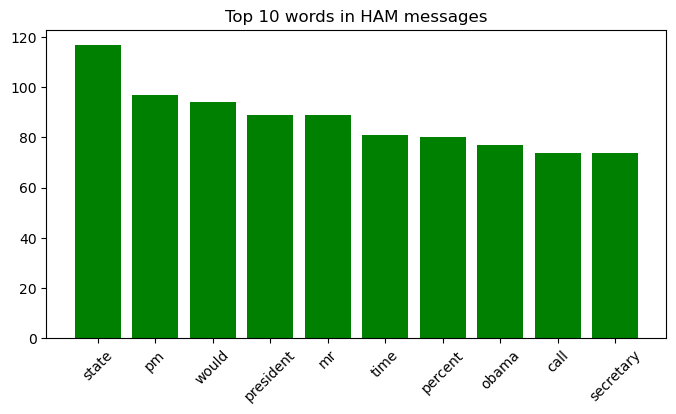

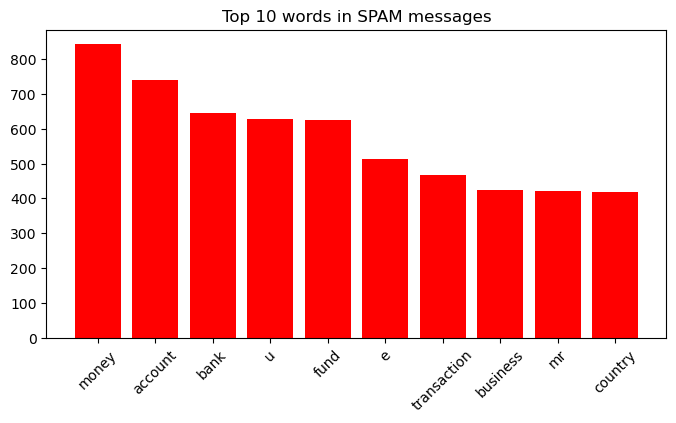

In [29]:
import matplotlib.pyplot as plt

# HAM
ham_top10 = dict(ham_words.most_common(10))
plt.figure(figsize=(8,4))
plt.bar(ham_top10.keys(), ham_top10.values(), color='green')
plt.title("Top 10 words in HAM messages")
plt.xticks(rotation=45)
plt.show()

# SPAM
spam_top10 = dict(spam_words.most_common(10))
plt.figure(figsize=(8,4))
plt.bar(spam_top10.keys(), spam_top10.values(), color='red')
plt.title("Top 10 words in SPAM messages")
plt.xticks(rotation=45)
plt.show()


#### To get Bag of Words features:


In [30]:
from nltk import probability
import math

def bag_of_words(words):
        return dict([(word, True) for word in words])

def bag_of_words_in_set(words, wordset):
        return bag_of_words(set(words) & wordset)
    
def word_counts(words):
        return dict(probability.FreqDist((w for w in words)))

def word_counts_in_set(words, wordset):
        return word_counts((w for w in words if w in wordset))

def train_test_feats(label, instances, featx=bag_of_words, fraction=0.75):
        labeled_instances = [(featx(i), label) for i in instances]
        
        if fraction != 1.0:
                l = len(instances)
                cutoff = int(math.ceil(l * fraction))
                return labeled_instances[:cutoff], labeled_instances[cutoff:]
        else:
                return labeled_instances, labeled_instances


In [31]:
# For HAM messages (label=0)
ham_instances = data_train[data_train['label']==0]['clean_text6_lemmatized'].tolist()
ham_feats, _ = train_test_feats(label=0, instances=ham_instances, featx=bag_of_words, fraction=1.0)

# For SPAM messages (label=1)
spam_instances = data_train[data_train['label']==1]['clean_text6_lemmatized'].tolist()
spam_feats, _ = train_test_feats(label=1, instances=spam_instances, featx=bag_of_words, fraction=1.0)


In [32]:
from collections import Counter

# Flatten all words from HAM
all_ham_words = [word for feat, _ in ham_feats for word in feat.keys()]
ham_word_counts = Counter(all_ham_words)

# Flatten all words from SPAM
all_spam_words = [word for feat, _ in spam_feats for word in feat.keys()]
spam_word_counts = Counter(all_spam_words)

# Top 10 words
print("Top 10 words in HAM:", ham_word_counts.most_common(10))
print("Top 10 words in SPAM:", spam_word_counts.most_common(10))


Top 10 words in HAM: [('call', 59), ('state', 55), ('fyi', 44), ('time', 43), ('would', 41), ('work', 38), ('see', 33), ('back', 32), ('u', 32), ('also', 31)]
Top 10 words in SPAM: [('u', 242), ('money', 237), ('million', 236), ('fund', 228), ('business', 211), ('account', 208), ('mr', 203), ('transaction', 202), ('dollar', 200), ('country', 197)]


## Extra features

In [34]:
data_train

,text,label,clean_text2_html,clean_text3_normalized,clean_text4_no_stopwords,clean_text5_tokens,clean_text6_lemmatized,clean_text6_lemmatized_str,money_mark,suspicious_words,text_len
29,"----------- REGARDS, MR NELSON SMITH.KINDLY RE...",1,"----------- REGARDS, MR NELSON SMITH.KINDLY RE...",regards mr nelson smith kindly reply me on my ...,regards mr nelson smith kindly reply private e...,"[regards, mr, nelson, smith, kindly, reply, pr...","[regard, mr, nelson, smith, kindly, reply, pri...",regard mr nelson smith kindly reply private em...,0,0,79
535,I have not been able to reach oscar this am. W...,0,I have not been able to reach oscar this am. W...,have not been able to reach oscar this am we a...,able reach oscar supposed send pdb receive,"[able, reach, oscar, supposed, send, pdb, rece...","[able, reach, oscar, supposed, send, pdb, rece...",able reach oscar supposed send pdb receive,0,0,42
695,; Huma Abedin B6I'm checking with Pat on the 5...,0,; Huma Abedin B6I'm checking with Pat on the 5...,huma abedin i checking with pat on the will wo...,huma abedin checking pat work jack jake rest a...,"[huma, abedin, checking, pat, work, jack, jake...","[huma, abedin, checking, pat, work, jack, jake...",huma abedin checking pat work jack jake rest a...,0,0,76
557,I can have it announced here on Monday - can't...,0,I can have it announced here on Monday - can't...,can have it announced here on monday can today,announced monday today,"[announced, monday, today]","[announced, monday, today]",announced monday today,0,0,22
836,BANK OF AFRICAAGENCE SAN PEDRO14 BP 1210 S...,1,BANK OF AFRICAAGENCE SAN PEDRO14 BP 1210 San P...,bank of africaagence san pedro bp san pedro co...,bank africaagence san pedro bp san pedro cote ...,"[bank, africaagence, san, pedro, bp, san, pedr...","[bank, africaagence, san, pedro, bp, san, pedr...",bank africaagence san pedro bp san pedro cote ...,1,1,1052
...,...,...,...,...,...,...,...,...,...,...,...
106,7653 2612ADAMA IBRAHIM________________________...,1,7653 2612ADAMA IBRAHIM________________________...,adama ibrahim tout savoir sur la curit de votr...,adama ibrahim tout savoir sur la curit de votr...,"[adama, ibrahim, tout, savoir, sur, la, curit,...","[adama, ibrahim, tout, savoir, sur, la, curit,...",adama ibrahim tout savoir sur la curit de votr...,0,0,99
270,What does that mean for our schedules?,0,What does that mean for our schedules?,what does that mean for our schedules,mean schedules,"[mean, schedules]","[mean, schedule]",mean schedule,0,0,13
860,"Dear Friend,My Compliment to you,I guess this ...",1,"Dear Friend,My Compliment to you,I guess this ...",dear friend my compliment to you guess this le...,dear friend compliment guess letter may come s...,"[dear, friend, compliment, guess, letter, may,...","[dear, friend, compliment, guess, letter, may,...",dear friend compliment guess letter may come s...,1,1,1452
435,Dear PRESIDENT=2FDIRECTOR=2C My name is Mr=2E ...,1,Dear PRESIDENT=2FDIRECTOR=2C My name is Mr=2E ...,dear president fdirector my name is mr micheal...,dear president fdirector name mr micheal ipenz...,"[dear, president, fdirector, name, mr, micheal...","[dear, president, fdirector, name, mr, micheal...",dear president fdirector name mr micheal ipenz...,1,1,2109


In [36]:
# If data_val['clean_text6_lemmatized'] exists as lists of tokens
data_val['clean_text6_lemmatized_str'] = data_val['clean_text6_lemmatized'].apply(lambda x: " ".join(x))

In [37]:
money_simbol_list = "|".join(["euro","dollar","pound","€",r"\$"])
suspicious_words = "|".join(["free","cheap","sex","money","account","bank","fund","transfer","transaction","win","deposit","password"])

# Use the string version of the cleaned text
data_train['money_mark'] = data_train['clean_text6_lemmatized_str'].str.contains(money_simbol_list)*1
data_train['suspicious_words'] = data_train['clean_text6_lemmatized_str'].str.contains(suspicious_words)*1
data_train['text_len'] = data_train['clean_text6_lemmatized_str'].apply(lambda x: len(x)) 

data_val['money_mark'] = data_val['clean_text6_lemmatized_str'].str.contains(money_simbol_list)*1
data_val['suspicious_words'] = data_val['clean_text6_lemmatized_str'].str.contains(suspicious_words)*1
data_val['text_len'] = data_val['clean_text6_lemmatized_str'].apply(lambda x: len(x)) 

data_train.head()


,text,label,clean_text2_html,clean_text3_normalized,clean_text4_no_stopwords,clean_text5_tokens,clean_text6_lemmatized,clean_text6_lemmatized_str,money_mark,suspicious_words,text_len
29,"----------- REGARDS, MR NELSON SMITH.KINDLY RE...",1,"----------- REGARDS, MR NELSON SMITH.KINDLY RE...",regards mr nelson smith kindly reply me on my ...,regards mr nelson smith kindly reply private e...,"[regards, mr, nelson, smith, kindly, reply, pr...","[regard, mr, nelson, smith, kindly, reply, pri...",regard mr nelson smith kindly reply private em...,0,0,79
535,I have not been able to reach oscar this am. W...,0,I have not been able to reach oscar this am. W...,have not been able to reach oscar this am we a...,able reach oscar supposed send pdb receive,"[able, reach, oscar, supposed, send, pdb, rece...","[able, reach, oscar, supposed, send, pdb, rece...",able reach oscar supposed send pdb receive,0,0,42
695,; Huma Abedin B6I'm checking with Pat on the 5...,0,; Huma Abedin B6I'm checking with Pat on the 5...,huma abedin i checking with pat on the will wo...,huma abedin checking pat work jack jake rest a...,"[huma, abedin, checking, pat, work, jack, jake...","[huma, abedin, checking, pat, work, jack, jake...",huma abedin checking pat work jack jake rest a...,0,0,76
557,I can have it announced here on Monday - can't...,0,I can have it announced here on Monday - can't...,can have it announced here on monday can today,announced monday today,"[announced, monday, today]","[announced, monday, today]",announced monday today,0,0,22
836,BANK OF AFRICAAGENCE SAN PEDRO14 BP 1210 S...,1,BANK OF AFRICAAGENCE SAN PEDRO14 BP 1210 San P...,bank of africaagence san pedro bp san pedro co...,bank africaagence san pedro bp san pedro cote ...,"[bank, africaagence, san, pedro, bp, san, pedr...","[bank, africaagence, san, pedro, bp, san, pedr...",bank africaagence san pedro bp san pedro cote ...,1,1,1052


## How would work the Bag of Words with Count Vectorizer concept?

In [40]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize Count Vectorizer
count_vectorizer = CountVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.8,
    stop_words='english'
)

# Fit and transform
X_train_count = count_vectorizer.fit_transform(data_train['clean_text6_lemmatized_str'])
X_val_count = count_vectorizer.transform(data_val['clean_text6_lemmatized_str'])

print("=== COUNT VECTORIZER ===")
print(f"Training features shape: {X_train_count.shape}")

=== COUNT VECTORIZER ===
Training features shape: (800, 5000)


## TF-IDF

- Load the vectorizer

- Vectorize all dataset

- print the shape of the vetorized dataset

In [41]:
# Your code

from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer with some useful parameters
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,           # Keep only top 5000 most frequent words
    min_df=2,                    # Ignore words that appear in less than 2 documents
    max_df=0.8,                  # Ignore words that appear in more than 80% of documents
    stop_words='english',        # Remove English stopwords (optional since you already did this)
    ngram_range=(1, 2)           # Consider both single words and word pairs (bigrams)
)

print("TF-IDF Vectorizer loaded successfully!")
print("Parameters set:")
print(f"  - max_features: {tfidf_vectorizer.max_features}")
print(f"  - min_df: {tfidf_vectorizer.min_df}")
print(f"  - max_df: {tfidf_vectorizer.max_df}")
print(f"  - ngram_range: {tfidf_vectorizer.ngram_range}")

TF-IDF Vectorizer loaded successfully!
Parameters set:
  - max_features: 5000
  - min_df: 2
  - max_df: 0.8
  - ngram_range: (1, 2)


Step 2: Vectorize the Dataset


In [43]:
# Make sure we're using the final cleaned text
# Based on your column names, use the lemmatized text version
print("Using text from column: clean_text6_lemmatized_str")

# Fit and transform the training data (learn vocabulary + transform)
X_train_tfidf = tfidf_vectorizer.fit_transform(data_train['clean_text6_lemmatized_str'])

# Transform the validation data (using the same vocabulary)
X_val_tfidf = tfidf_vectorizer.transform(data_val['clean_text6_lemmatized_str'])

print("Dataset vectorization completed!")

Using text from column: clean_text6_lemmatized_str
Dataset vectorization completed!


In [44]:
print("=== TF-IDF VECTORIZATION RESULTS ===")
print(f"Training set shape: {X_train_tfidf.shape}")
print(f"Validation set shape: {X_val_tfidf.shape}")
print(f"Number of features (words/ngrams): {X_train_tfidf.shape[1]}")

# Get the target labels
y_train = data_train['label']
y_val = data_val['label']
print(f"Training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_val.shape}")

=== TF-IDF VECTORIZATION RESULTS ===
Training set shape: (800, 5000)
Validation set shape: (200, 5000)
Number of features (words/ngrams): 5000
Training labels shape: (800,)
Validation labels shape: (200,)


In [45]:
# See some of the features (words) that were extracted
feature_names = tfidf_vectorizer.get_feature_names_out()
print("\n=== SAMPLE FEATURES (WORDS) ===")
print("First 20 features:")
print(feature_names[:20])

print("\nLast 20 features:")
print(feature_names[-20:])

# Check the most frequent words
print(f"\nTotal vocabulary size: {len(feature_names)} words")


=== SAMPLE FEATURES (WORDS) ===
First 20 features:
['aa' 'ab' 'abacha' 'abandoned' 'abandoned sum' 'abbas' 'abedin'
 'abedin huma' 'abidjan' 'abidjan cote' 'abidjan economic'
 'abidjan secretly' 'ability' 'able' 'abm' 'abn' 'abroad' 'abroad know'
 'absolute' 'absolutely']

Last 20 features:
['zf' 'zh' 'zimbabwe' 'zimbabwean' 'zj' 'zk' 'zl' 'zn' 'zone' 'zp' 'zr'
 'zsb' 'zt' 'zuma' 'zv' 'zw' 'zx' 'zxj' 'zywn' 'zywn aw']

Total vocabulary size: 5000 words


In [49]:
# Let's see what TF-IDF actually looks like for a sample message
print("\n=== TF-IDF REPRESENTATION EXAMPLE ===")
sample_idx = 0  # Look at first message

if sample_idx < X_train_tfidf.shape[0]:
    # Get the TF-IDF scores for the first document
    sample_tfidf = X_train_tfidf[sample_idx]
    
    # Convert to array and find non-zero values
    tfidf_array = sample_tfidf.toarray().flatten()
    non_zero_indices = np.where(tfidf_array > 0)[0]
    
    print(f"Message {sample_idx} (Label: {'SPAM' if y_train.iloc[sample_idx] == 1 else 'HAM'}):")
    print(f"Original text: {data_train['clean_text6_lemmatized_str'].iloc[sample_idx][:100]}...")
    print(f"Number of non-zero TF-IDF features: {len(non_zero_indices)}")
    
    # Show top 5 words with highest TF-IDF scores
    if len(non_zero_indices) > 0:
        top_indices = non_zero_indices[np.argsort(tfidf_array[non_zero_indices])[-5:]][::-1]  # Top 5 highest scores
        print("Top 5 words with highest TF-IDF scores:")
        for idx in top_indices:
            print(f"  '{feature_names[idx]}': {tfidf_array[idx]:.4f}")


=== TF-IDF REPRESENTATION EXAMPLE ===
Message 0 (Label: SPAM):
Original text: regard mr nelson smith kindly reply private email address nelsonsmith yahoo com...
Number of non-zero TF-IDF features: 17
Top 5 words with highest TF-IDF scores:
  'nelson': 0.3747
  'kindly reply': 0.3334
  'reply private': 0.3145
  'smith': 0.3093
  'yahoo com': 0.2922


In [51]:
# Step 1: Load Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.8,
    stop_words='english',
    ngram_range=(1, 2)
)

# Step 2: Vectorize Dataset
X_train_tfidf = tfidf_vectorizer.fit_transform(data_train['clean_text6_lemmatized_str'])
X_val_tfidf = tfidf_vectorizer.transform(data_val['clean_text6_lemmatized_str'])

# Step 3: Print Shapes
print("=== TF-IDF VECTORIZATION ===")
print(f"Training features shape: {X_train_tfidf.shape}")
print(f"Validation features shape: {X_val_tfidf.shape}")
print(f"Number of features: {X_train_tfidf.shape[1]}")

=== TF-IDF VECTORIZATION ===
Training features shape: (800, 5000)
Validation features shape: (200, 5000)
Number of features: 5000


## And the Train a Classifier?

In [52]:
# Your code

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Create the model
model = MultinomialNB()

# Train on TF-IDF features
model.fit(X_train_tfidf, data_train['label'])


y_pred = model.predict(X_val_tfidf)

In [53]:
# Accuracy
acc = accuracy_score(data_val['label'], y_pred)
print(f"Validation Accuracy: {acc:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(data_val['label'], y_pred))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(data_val['label'], y_pred))


Validation Accuracy: 0.9800

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       125
           1       0.97      0.97      0.97        75

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200


Confusion Matrix:
[[123   2]
 [  2  73]]
